In [103]:
include("NTKernel.jl");

In [292]:
# PSUDEO data
g = x -> cos(x)          # anonymous function g(x)

X = range(0, stop=4pi, length=60)
X = Matrix(reshape(X, 1, :))        # reshape, each column vector is read as data point

Y = map(g,X);                       # Map with g(x)

In [302]:
# nodes on hidden layer

function create_model(Ni, Nh, No, N, activation)
    layers = [] # Initialize an empty array without specifying the type of elements
    push!(layers, Dense(Ni, N, activation)) # First hidden layer with N nodes and specified activation
    for _ in 2:Nh
        push!(layers, Dense(N, N, activation)) # Additional Nh-1 hidden layers
    end
    push!(layers, Dense(N, No)) # Output layer without specifying an activation function (defaults to identity)
    model = Chain(layers...)|>f64 # Create the model from the layers
    return model
end


Nh_list = [700] 
H_Layers = [1]
models = []
activation = sigmoid

InputDim = 1

models = []
for Nh in 1:length(Nh_list)
    for Layer in 1:length(H_Layers)
        push!(models, create_model(InputDim,H_Layers[Layer],InputDim,Nh_list[Nh],activation))
    end
end

Kernels = []
for model in models
    push!(Kernels, kernel(model, X))
end

Kernels_Norms = []
# Iterate over each kernel and normalize according to your pattern
for i in 1:length(Kernels)
    # Use mod1 to cycle through Nh_list based on i
    # This approach correctly associates each kernel with its Nh value according to your pattern
    Nh_index = mod1(i, length(Nh_list))
    Nh = Nh_list[Nh_index]
    normalized_K = Kernels[i] / sqrt(Nh)
    push!(Kernels_Norms, normalized_K)
end
λ_values = []
for K in Kernels_Norms
    push!(λ_values, eigen(K).values) # Compute eigenvalues for each kernel and store
end


In [307]:
# for i in 1:length(models)
#     display(models[i])
# end



loss(model, x, y) = Flux.Losses.mse(model(x),y)

opt = Descent(1/λ_values[1][end])
data = [(X, Y)]
Nepoch=1_500_000

λ_big = []
for λ in λ_values[1]
    if λ > 10^-6
        push!(λ_big,λ)
    end
end
count = length(λ_values[1])
big_count = length(λ_big)

MySnapsLoc = [300_000] #insert your locations
MySnaps = Vector{Vector}()

for epoch=1:Nepoch
    Flux.train!(loss, models[1], data, opt)
    if epoch in MySnapsLoc
        push!(MySnaps, map_model(models[1],X))
    end
end
Y_fit = map_model(models[1],X)
MySnapsLoc = MySnapsLoc[1]


# display(Y_fit)
# display(MySnaps)
loss_updt = round(loss(models[1],X,Y),digits=3)
λ_values[1] .= abs.(λ_values[1])
λ_values[1] .= sort!(λ_values[1])

60-element Vector{Float64}:
   5.744647721191664e-16
   7.042786440702047e-16
   7.392303670840276e-16
   7.460888455717432e-16
   8.881784197001252e-16
   8.881784197001252e-16
   8.881784197001252e-16
   9.324979561871383e-16
   9.755802779990722e-16
   9.922625558570266e-16
   ⋮
   2.7533531010703882e-14
   3.1974423335584724e-14
   1.7536481360442902e-13
   5.0160605191439674e-11
   8.260179377952006e-8
   2.1710066386674948e-6
   0.005727293556649931
   6.534055160354544
 413.88894690586096

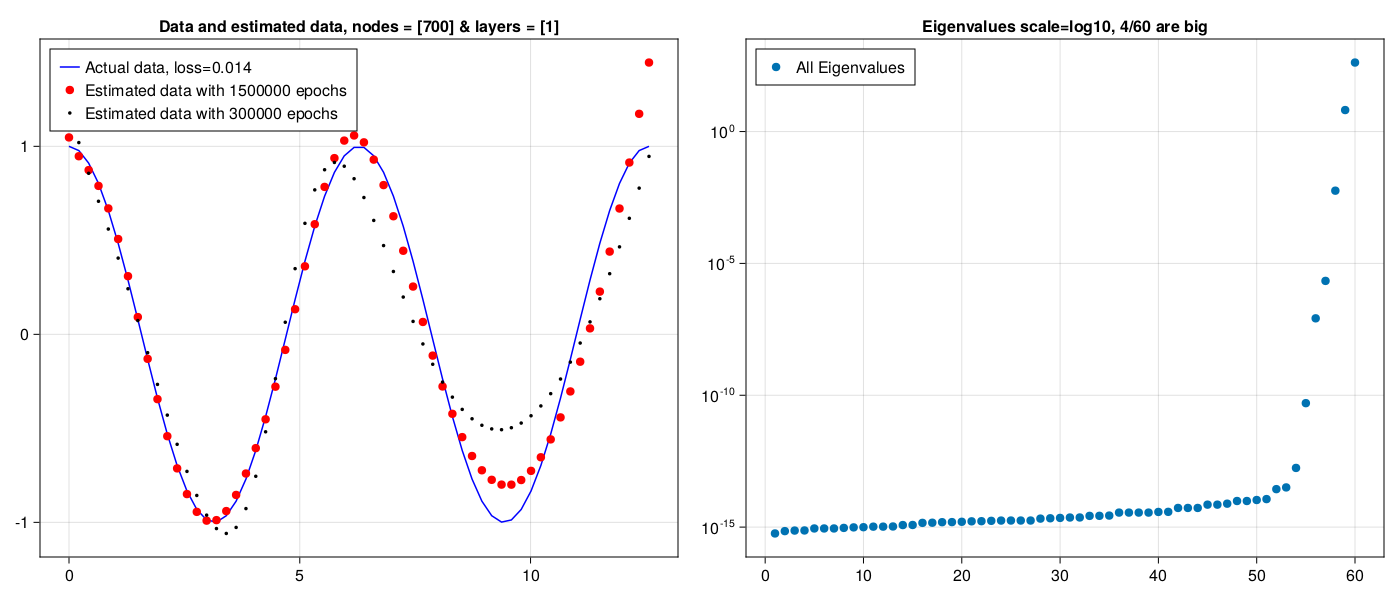

In [308]:
using CairoMakie

fig = Figure(resolution = (1400, 600))
ax1 = Axis(fig[1, 1], title = "Data and estimated data, nodes = $Nh_list & layers = $H_Layers")
ax2 = Axis(fig[1, 2], title = "Eigenvalues scale=log10, $big_count/$count are big",yscale=log10)
s1 = lines!(ax1, X[:], Y[:], color =:blue, label="Actual data, loss=$loss_updt")
s2 = scatter!(ax1, X[:],Y_fit[:], color =:red, label="Estimated data with $Nepoch epochs")
s3 = scatter!(ax1, X[:],MySnaps[1], color =:black, label="Estimated data with $MySnapsLoc epochs", markersize = 5)
scatter!(ax2,λ_values[1],label=" All Eigenvalues")



# Create a legend for ax1 with the specified scatter plots
axislegend(ax1,position=:lt)
axislegend(ax2,position=:lt)



fig